In [1]:
# add description - goal is to compare the impact of different mandible directions


In [125]:
from hsflfm.analysis import build_bulk_analyzer 
import numpy as np 
from matplotlib import pyplot as plt 
from build_grid import build_grid
import os 
from pathlib import Path 
from tqdm import tqdm 
from hsflfm.util import load_dictionary, MetadataManager
import matplotlib 

In [183]:
result_folder = "../complete_results_20241227"
result_folder = "../complete_results_pseudo_inverse_20250803"

reload = False   
analyzer = build_bulk_analyzer(result_folder, reload=reload)

In [184]:
# remove all points that don't meet a defined error threshold
# error threhsold is in pixels^2 
total_points = len(analyzer.all_results["specimen_number"])
analyzer.enforce_error_threshold(0.0015) 
safe_points = len(analyzer.all_results["specimen_number"])

print(f"total # points: {total_points}")
print(f"after enforcing error threshold: {safe_points}")
print(f"{safe_points/total_points * 100:.1f}%")

total # points: 14061
after enforcing error threshold: 11556
82.2%


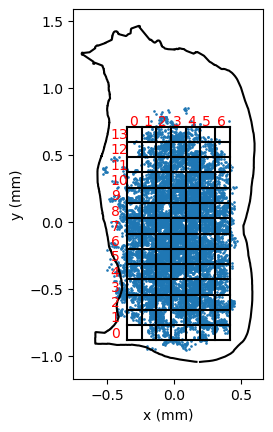

In [185]:
x_bounds, y_bounds = build_grid(analyzer=analyzer, show_numbers=True)

In [186]:
# pick grid regions to compare 
grid0 = [8, 3]
grid1 = [2, 3]
radius_std = 200 # points should be within this distance of the center of the grid to be included 

centerx_0 = (x_bounds[grid0[0]] + x_bounds[grid0[0] + 1]) / 2
centery_0 = (y_bounds[grid0[1]] + y_bounds[grid0[1] + 1]) / 2

centerx_1 = (x_bounds[grid1[0]] + x_bounds[grid1[0] + 1]) / 2
centery_1 = (y_bounds[grid1[1]] + y_bounds[grid1[1] + 1]) / 2

# find the points within those two regions 
strike_locations = analyzer.all_results["start_locations_std"].numpy() 
distances0 = np.linalg.norm(strike_locations[:, :2] - [centerx_0, centery_0], axis=1)
distances1 = np.linalg.norm(strike_locations[:, :2] - [centerx_1, centery_1], axis=1)

indices0 = distances0 < radius_std 
indices1 = distances1 < radius_std 

In [187]:
mandible_orders = []
vectors = []

for order in np.unique(analyzer.all_results["mandible_order"]):
    idx = analyzer.all_results["mandible_order"] == order
    idx0 = np.bitwise_and(idx, indices0)
    idx1 = np.bitwise_and(idx, indices1)

    # then find displacement vectors for each strike
    excluded_count = 0 
    for specimen in np.unique(analyzer.all_results["specimen_number"]):
        specimen_indices = analyzer.get_specimen_indices(specimen) 
        strike_numbers = np.unique(analyzer.all_results["strike_number"][specimen_indices])
        for sn in strike_numbers:
            strike_indices = analyzer.get_specimen_indices(specimen, sn) 
            strike_idx0 = np.intersect1d(strike_indices, np.where(idx0)) 
            strike_idx1 = np.intersect1d(strike_indices, np.where(idx1))
            displacement0 = analyzer.all_results["displacement"][strike_idx0]
            displacement1 = analyzer.all_results["displacement"][strike_idx1]

            if len(displacement0) < 1 or len(displacement1) < 1:
                continue 
            # average the points 
            displacement0 = np.mean(displacement0.numpy(), axis=0) 
            displacement1 = np.mean(displacement1.numpy(), axis=0) 
            diff = displacement0 - displacement1 

            mandible_orders.append(order)
            vectors.append(diff) 
    
mandible_orders = np.asarray(mandible_orders)
vectors = np.asarray(vectors)

In [188]:
# print averages for strikes with and without the left mandible
set0 = vectors[mandible_orders != "R only"] 
set0_norm = np.linalg.norm(set0, axis=-1) * 1e3 
print(f"with left: mean {np.mean(set0_norm):.2f} um, max {np.max(set0_norm):.2f} um, dev {np.std(set0_norm):.2f} um")

# print averages for strikes with and without the left mandible
set1 = vectors[mandible_orders == "R only"] 
set1_norm = np.linalg.norm(set1, axis=-1) * 1e3 
print(f"without left: mean {np.mean(set1_norm):.2f} um, max {np.max(set1_norm):.2f} um, dev {np.std(set1_norm):.2f} um")


with left: mean 17.67 um, max 47.99 um, dev 8.68 um
without left: mean 2.84 um, max 7.52 um, dev 1.69 um


S: 42 strikes
L: 82 strikes
L only: 49 strikes
R: 63 strikes
R only: 26 strikes


C:\Users\clare\AppData\Local\Temp\ipykernel_17540\2590299489.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  _ = plt.boxplot(bars, labels=labels)


Text(0, 0.5, 'Displacement (um)')

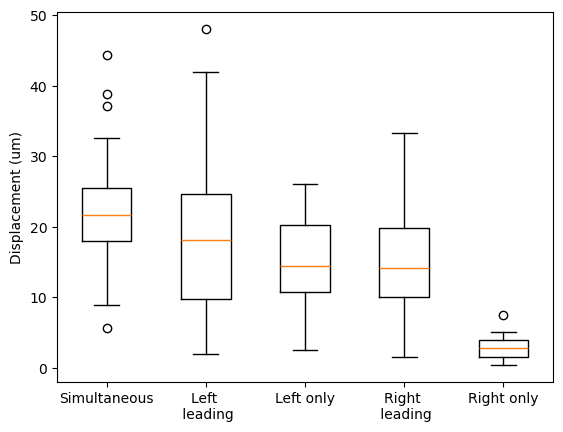

In [ ]:
keys = ["S", "L", "L only", "R", "R only"]
bars = []
for key in keys:
    idx = np.where(mandible_orders == key)
    axial = vectors[idx] * 1e3 
    axial = np.linalg.norm(axial, axis=-1)
    bars.append(axial.squeeze().tolist()) 
    print(f"{key}: {len(axial)} strikes")
plt.figure()
labels = ["Simultaneous", "Left \n leading", "Left only", "Right \n leading", "Right only"]
_ = plt.boxplot(bars, labels=labels) 
plt.ylabel("Displacement (um)")

In [ ]:
# next, compare directions of head movement 
# for this, we will need to load the individual result files 
# get all the filenames
all_filenames = []
folders = os.listdir(result_folder)
for inner in folders:
    path = Path(result_folder) / inner
    if path.is_dir():
        filenames = os.listdir(path)
        for filename in filenames:
            if filename[-4:] == "json":
                all_filenames.append(str(path / filename))

max_values = []
orders = []
specimens = []
strike_numbers = []

for f in tqdm(all_filenames):
    results = load_dictionary(f) 
    mm = MetadataManager(results["specimen_number"])
    order = mm.mandible_order(results["strike_number"])
    orders.append(order) 

    gm = results["global_movement"]
    num_frames = len(gm["x"])
    vals = np.zeros((num_frames, 3)) 
    vals[:, 0] = gm["x"] 
    vals[:, 1] = gm["y"]
    vals[:, 2] = gm["z"]

    avg_vals = np.linalg.norm(vals, axis=1) 
    frame = np.argmax(avg_vals) 


    specimens.append(results["specimen_number"])
    strike_numbers.append(results["strike_number"]) 
    keep_vals = vals[frame] 

    max_values.append(keep_vals.tolist())

max_values = np.asarray(max_values) 
tmp = max_values[:, 0].copy() 
max_values[:, 0] = -max_values[:, 1] 
max_values[:, 1] = tmp 


  0%|          | 0/329 [00:00<?, ?it/s]

100%|██████████| 329/329 [02:18<00:00,  2.38it/s]


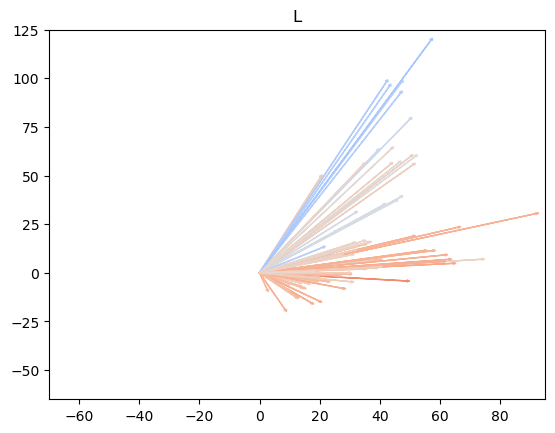

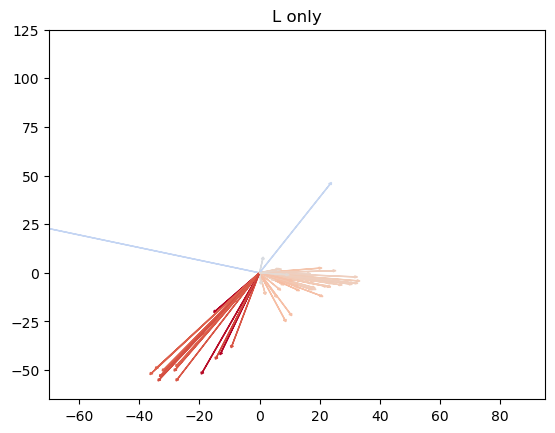

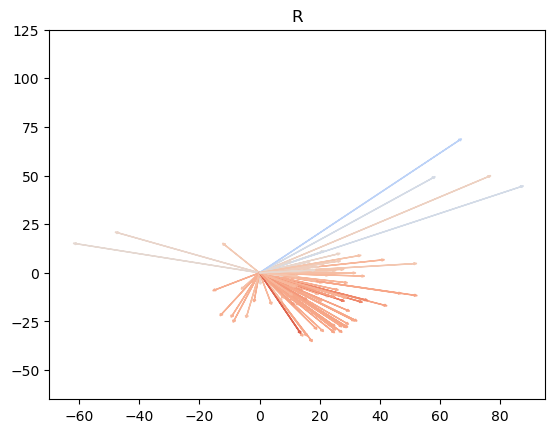

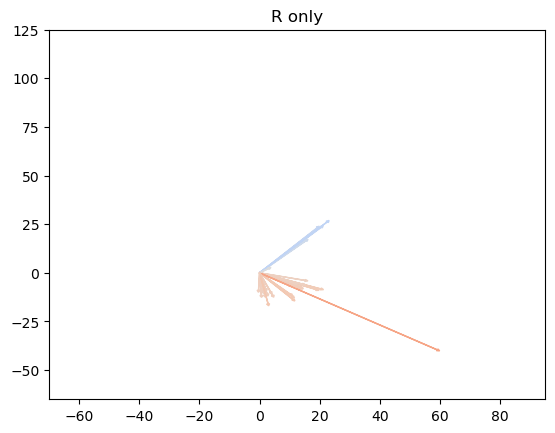

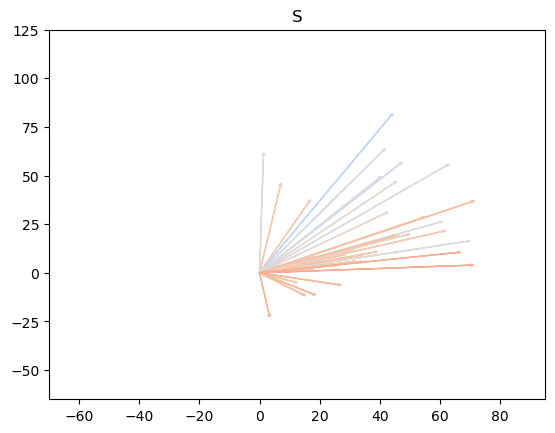

In [156]:
scaled_mv = max_values * 1e3
maxz = np.max(np.abs(scaled_mv[:, 2]))
minz = -maxz 
cmap = matplotlib.cm.coolwarm
for key in np.unique(orders):
    indices = np.where(np.asarray(orders) == key)[0]
    vals = scaled_mv[indices] 

    plt.figure()
    for v in vals:
        plt.arrow(0, 0, v[0], v[1], color=cmap((v[2] - minz) / (maxz - minz)),
                  width=0.05, head_width=1, head_length=1)

    plt.title(key) 
    ax = plt.gca()
    ax.set_ylim(-65, 125)
    ax.set_xlim(-70, 95)

(-70.0, 95.0)

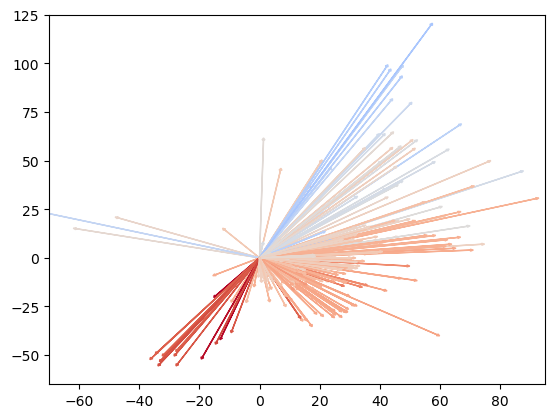

In [157]:
plt.figure()
for v, o in zip(scaled_mv, orders):
    color = cmap((v[2] - minz) / (maxz - minz))
    plt.arrow(0, 0, v[0], v[1], color=color, width=0.05, head_width=1, head_length=1)

ax = plt.gca()
ax.set_ylim(-65, 125)
ax.set_xlim(-70, 95)